# EDAN95 - Applied Machine Learning
### LTH Fall 2019

# Lab 6
### Jonas Lundgren

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt

from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
from sklearn import metrics
from scipy.stats import multivariate_normal

In [2]:
digits = load_digits()
train_features, test_features, train_labels, test_labels = train_test_split(digits.data, digits.target,
                                                                            test_size=0.3, random_state=42)

train_features /= 16 
test_features /= 16 

In [3]:
class Gaussian_NBC_EM():
    
    def __init__(self, seed = 42, epsilon = 1e-3):
        self.seed = seed
        self.epsilon = epsilon
    
    def log_prob(self, X, mu, sigma2):
        return np.log(1/np.sqrt(2*np.pi*sigma2)) - 1/(2*sigma2) * (X - mu)**2
    
    def prob(self, x, mu, sigma2):        
        return 1/np.sqrt(2*np.pi*sigma2) * np.exp(- 1/(2*sigma2) * (x - mu)**2)
    
    def fit(self, X, K):
        self.K = K
        np.random.seed(self.seed)
        n_samples, n_features = np.shape(X)
        
        prior = np.ones(K)/K
        
        idxs = np.resize(range(K), n_samples)
        np.random.shuffle(idxs)
        
        mu = np.empty([K, n_features])
        sigma2 = np.empty([K, n_features])
        for k in range(K):
            mu[k] = np.mean(X[idxs == k], axis=0)
            sigma2[k] = np.var(X[idxs == k], axis=0)
        
        sigma2 += self.epsilon
        
        P = np.empty([n_samples, K])
        r = np.empty([n_samples, K])
        prev_prior = np.zeros(K)
        
        while np.linalg.norm(prev_prior - prior) > 1e-6:
                             
            # E step
            for k in range(K):
                P[:, k] = np.prod(self.prob(X, mu[k], sigma2[k]), axis = 1)
                
            r = prior * P / (np.sum(prior * P, axis = 1)).reshape(-1,1)
            
            # M step
            r_k = np.sum(r, axis = 0)
            prev_prior = prior #For stop condition
            prior = r_k / np.sum(r_k)
                             
            for k in range(K):
                mu[k] = np.sum(r[:, k].reshape(-1,1) * X, axis = 0) / r_k[k]
                sigma2[k] = np.diag((r[:, k].reshape(-1,1) * (X - mu[k])).T @ (X - mu[k]) / r_k[k])
                   
            sigma2 += self.epsilon
            
        
        self.mu = mu
        self.sigma2 = sigma2
        self.prior = prior
        
    def predict(self, X):
        preds = np.empty(len(X), dtype = np.int32)
        prob = np.zeros(self.K)
        
        for i, x in enumerate(X):
            for k in range(self.K):                
                prob[k] = self.prior[k] * np.prod(self.prob(x, self.mu[k], self.sigma2[k]))
                  
            preds[i] = np.argmax(prob)
        
        self.preds = preds
        return self.preds

In [4]:
em = Gaussian_NBC_EM()
em.fit(train_features, K = 10)

## Train Data

In [5]:
ypreds = em.predict(train_features)
print("Confusion matrix:\n%s" % metrics.confusion_matrix(train_labels, ypreds))

Confusion matrix:
[[  0   0 123   0   2   0   0   0   0   0]
 [  0   4   0   0   1  41  61   1   4  20]
 [  0   0   0   0   0   0  14   0  70  46]
 [ 90   3   0   0   0   0  19  12   2   3]
 [  0  10   0   0  99  10   0   1   1   0]
 [  9   4   0   0   0   0   1  68  34   0]
 [  0   0   0 125   1   0   0   2   0   0]
 [  0 116   0   0   0   3   4   1   0   0]
 [  1   1   0   0   2   3  63  49   6   6]
 [ 90   7   0   0   0  14   0   8   1   1]]


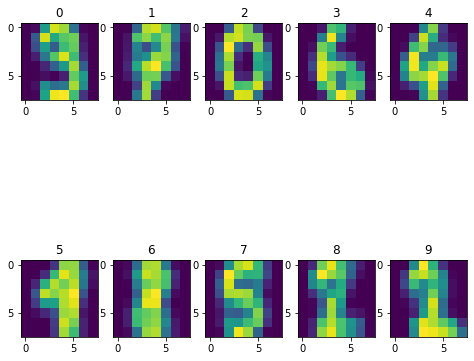

In [6]:
fig = plt.figure(figsize=(8, 8))
columns = 5
rows = 2
for i in range(10):
    img = np.reshape(em.mu[i]*16,(8,8))
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(img)
    plt.title(i)
plt.show()

In [7]:
preds_fix = np.zeros(len(ypreds))
preds_fix[ypreds == 0] = 3
preds_fix[ypreds == 1] = 7
preds_fix[ypreds == 2] = 0
preds_fix[ypreds == 3] = 6
preds_fix[ypreds == 4] = 4
preds_fix[ypreds == 5] = 9
preds_fix[ypreds == 6] = 8
preds_fix[ypreds == 7] = 5
preds_fix[ypreds == 8] = 2
preds_fix[ypreds == 9] = 1

In [8]:
print("Confusion matrix:\n%s" % metrics.confusion_matrix(train_labels, preds_fix))

Confusion matrix:
[[123   0   0   0   2   0   0   0   0   0]
 [  0  20   4   0   1   1   0   4  61  41]
 [  0  46  70   0   0   0   0   0  14   0]
 [  0   3   2  90   0  12   0   3  19   0]
 [  0   0   1   0  99   1   0  10   0  10]
 [  0   0  34   9   0  68   0   4   1   0]
 [  0   0   0   0   1   2 125   0   0   0]
 [  0   0   0   0   0   1   0 116   4   3]
 [  0   6   6   1   2  49   0   1  63   3]
 [  0   1   1  90   0   8   0   7   0  14]]


In [9]:
metrics.accuracy_score(train_labels, preds_fix)

0.6268894192521878

## Test Data

In [10]:
ypreds = em.predict(test_features)
print("Confusion matrix:\n%s" % metrics.confusion_matrix(test_labels, ypreds))

Confusion matrix:
[[ 1  0 50  0  2  0  0  0  0  0]
 [ 0  2  0  0  1 15 18  2  2 10]
 [ 0  0  0  0  0  0  2  1 25 19]
 [34  0  0  0  0  0  9  7  0  4]
 [ 0  6  0  0 48  5  0  1  0  0]
 [10  2  0  1  0  0  1 39 13  0]
 [ 0  0  0 51  0  0  0  2  0  0]
 [ 0 54  0  0  0  0  0  1  0  0]
 [ 0  0  0  0  0  0 20 17  4  2]
 [45  3  0  0  0  5  1  4  1  0]]


In [11]:
preds_fix = np.zeros(len(ypreds))
preds_fix[ypreds == 0] = 3
preds_fix[ypreds == 1] = 7
preds_fix[ypreds == 2] = 0
preds_fix[ypreds == 3] = 6
preds_fix[ypreds == 4] = 4
preds_fix[ypreds == 5] = 9
preds_fix[ypreds == 6] = 8
preds_fix[ypreds == 7] = 5
preds_fix[ypreds == 8] = 2
preds_fix[ypreds == 9] = 1

In [12]:
print("Confusion matrix:\n%s" % metrics.confusion_matrix(test_labels, preds_fix))

Confusion matrix:
[[50  0  0  1  2  0  0  0  0  0]
 [ 0 10  2  0  1  2  0  2 18 15]
 [ 0 19 25  0  0  1  0  0  2  0]
 [ 0  4  0 34  0  7  0  0  9  0]
 [ 0  0  0  0 48  1  0  6  0  5]
 [ 0  0 13 10  0 39  1  2  1  0]
 [ 0  0  0  0  0  2 51  0  0  0]
 [ 0  0  0  0  0  1  0 54  0  0]
 [ 0  2  4  0  0 17  0  0 20  0]
 [ 0  0  1 45  0  4  0  3  1  5]]


In [13]:
metrics.accuracy_score(test_labels, preds_fix)

0.6222222222222222

# K-means 

In [14]:
from sklearn.cluster import KMeans

In [15]:
kmeans = KMeans(n_clusters=10, random_state = 42)
kmeans.fit(train_features)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=10, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

## Train Data

In [16]:
ypreds = kmeans.predict(train_features)
print("Confusion matrix:\n%s" % metrics.confusion_matrix(train_labels, ypreds))

Confusion matrix:
[[  0   0   0   0   0 124   0   1   0   0]
 [  3   0  74   0  14   0   0   0   1  40]
 [  0  11   2   2 106   1   6   0   0   2]
 [  0 114   0   6   1   0   6   0   2   0]
 [  0   0   3   6   0   0   3 108   0   1]
 [  0  17   0   0   0   0   0   0  99   0]
 [124   0   3   0   0   0   1   0   0   0]
 [  0   0   3 112   0   0   9   0   0   0]
 [  1  10   7   4   3   0  98   0   2   6]
 [  0  97   0   4   0   0   1   0   4  15]]


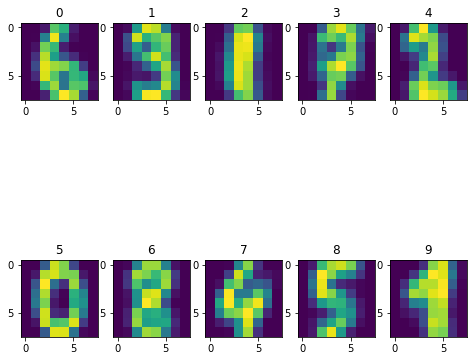

In [17]:
fig = plt.figure(figsize=(8, 8))
columns = 5
rows = 2
for i in range(10):
    img = np.reshape(kmeans.cluster_centers_[i]*16,(8,8))
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(img)
    plt.title(i)
plt.show()

In [18]:
preds_fix = np.zeros(len(ypreds))
preds_fix[ypreds == 0] = 6
preds_fix[ypreds == 1] = 3
preds_fix[ypreds == 2] = 1
preds_fix[ypreds == 3] = 7
preds_fix[ypreds == 4] = 2
preds_fix[ypreds == 5] = 0
preds_fix[ypreds == 6] = 8
preds_fix[ypreds == 7] = 4
preds_fix[ypreds == 8] = 5
preds_fix[ypreds == 9] = 9

In [19]:
print("Confusion matrix:\n%s" % metrics.confusion_matrix(train_labels, preds_fix))

Confusion matrix:
[[124   0   0   0   1   0   0   0   0   0]
 [  0  74  14   0   0   1   3   0   0  40]
 [  1   2 106  11   0   0   0   2   6   2]
 [  0   0   1 114   0   2   0   6   6   0]
 [  0   3   0   0 108   0   0   6   3   1]
 [  0   0   0  17   0  99   0   0   0   0]
 [  0   3   0   0   0   0 124   0   1   0]
 [  0   3   0   0   0   0   0 112   9   0]
 [  0   7   3  10   0   2   1   4  98   6]
 [  0   0   0  97   0   4   0   4   1  15]]


In [20]:
metrics.accuracy_score(train_labels, preds_fix)

0.7748607796340493

## Test data

In [21]:
ypreds = kmeans.predict(test_features)
print("Confusion matrix:\n%s" % metrics.confusion_matrix(test_labels, ypreds))

Confusion matrix:
[[ 0  0  0  0  0 52  0  1  0  0]
 [ 0  0 27  0 10  0  0  0  0 13]
 [ 0  2  0  0 41  0  4  0  0  0]
 [ 0 47  0  2  1  0  4  0  0  0]
 [ 0  0  2  2  0  0  0 54  0  2]
 [ 1 16  0  0  0  0  0  1 48  0]
 [52  0  0  0  0  1  0  0  0  0]
 [ 0  0  1 53  0  0  1  0  0  0]
 [ 0  3  3  0  0  0 36  0  1  0]
 [ 0 48  0  4  0  0  1  0  1  5]]


In [22]:
preds_fix = np.zeros(len(ypreds))
preds_fix[ypreds == 0] = 6
preds_fix[ypreds == 1] = 3
preds_fix[ypreds == 2] = 1
preds_fix[ypreds == 3] = 7
preds_fix[ypreds == 4] = 2
preds_fix[ypreds == 5] = 0
preds_fix[ypreds == 6] = 8
preds_fix[ypreds == 7] = 4
preds_fix[ypreds == 8] = 5
preds_fix[ypreds == 9] = 9

In [23]:
print("Confusion matrix:\n%s" % metrics.confusion_matrix(test_labels, preds_fix))

Confusion matrix:
[[52  0  0  0  1  0  0  0  0  0]
 [ 0 27 10  0  0  0  0  0  0 13]
 [ 0  0 41  2  0  0  0  0  4  0]
 [ 0  0  1 47  0  0  0  2  4  0]
 [ 0  2  0  0 54  0  0  2  0  2]
 [ 0  0  0 16  1 48  1  0  0  0]
 [ 1  0  0  0  0  0 52  0  0  0]
 [ 0  1  0  0  0  0  0 53  1  0]
 [ 0  3  0  3  0  1  0  0 36  0]
 [ 0  0  0 48  0  1  0  4  1  5]]


In [24]:
metrics.accuracy_score(test_labels, preds_fix)

0.7685185185185185